ENSF 444 Project - Group 85

In [69]:
import pandas as pd
import numpy as np

In [70]:
results_df = pd.read_csv('data/results.csv')
drivers_df = pd.read_csv('data/drivers.csv')
races_df = pd.read_csv('data/races.csv')
constructors_df = pd.read_csv('data/constructors.csv')
status_df = pd.read_csv('data/status.csv')

Transform Data

In [71]:
results_df.drop(['number','positionText','positionOrder','points','laps','time','milliseconds','fastestLap','rank','fastestLapTime','fastestLapSpeed'], axis=1, inplace=True)
results_df.rename(columns={'position':'final_position','grid':'starting_position'}, inplace=True)

results_df['final_position'] = results_df['final_position'].replace('\\N', np.nan)
results_df.final_position = pd.to_numeric(results_df.final_position)
print(results_df.dtypes)
results_df.head()

resultId               int64
raceId                 int64
driverId               int64
constructorId          int64
starting_position      int64
final_position       float64
statusId               int64
dtype: object


,resultId,raceId,driverId,constructorId,starting_position,final_position,statusId
0,1,18,1,1,1,1.0,1
1,2,18,2,2,5,2.0,1
2,3,18,3,3,7,3.0,1
3,4,18,4,4,11,4.0,1
4,5,18,5,1,3,5.0,1


In [72]:
drivers_df['driver_name'] = drivers_df['forename'] + ' ' + drivers_df['surname']
drivers_df.drop(['driverRef','number','code','forename','surname','dob','nationality','url'], axis=1, inplace=True)

print(drivers_df.dtypes)
drivers_df.head()

driverId        int64
driver_name    object
dtype: object


,driverId,driver_name
0,1,Lewis Hamilton
1,2,Nick Heidfeld
2,3,Nico Rosberg
3,4,Fernando Alonso
4,5,Heikki Kovalainen


In [73]:
races_df.drop(columns=['round','date','time','url','fp1_date','fp1_time','fp2_date','fp2_time','fp3_date','fp3_time','quali_date','quali_time','sprint_date','sprint_time',], axis=1, inplace=True)

print(races_df.dtypes)
races_df.head()

raceId        int64
year          int64
circuitId     int64
name         object
dtype: object


,raceId,year,circuitId,name
0,1,2009,1,Australian Grand Prix
1,2,2009,2,Malaysian Grand Prix
2,3,2009,17,Chinese Grand Prix
3,4,2009,3,Bahrain Grand Prix
4,5,2009,4,Spanish Grand Prix


In [74]:
constructors_df.drop(columns=['constructorRef','nationality','url'], axis=1, inplace=True)

print(constructors_df.dtypes)
constructors_df.head()

constructorId     int64
name             object
dtype: object


,constructorId,name
0,1,McLaren
1,2,BMW Sauber
2,3,Williams
3,4,Renault
4,5,Toro Rosso


In [75]:
print(status_df.dtypes)
status_df.head()


statusId     int64
status      object
dtype: object


,statusId,status
0,1,Finished
1,2,Disqualified
2,3,Accident
3,4,Collision
4,5,Engine


Combining Datasets

In [76]:
combined_df = pd.merge(results_df, races_df, on='raceId', how='inner')
combined_df = pd.merge(combined_df, drivers_df, on='driverId', how='inner')
combined_df = pd.merge(combined_df, constructors_df, on='constructorId', how='inner')
combined_df = pd.merge(combined_df, status_df, on='statusId', how='inner')
combined_df.drop_duplicates(subset=['raceId','driverId'], inplace=True)
combined_df.rename(columns={'name_x': 'race_name'}, inplace=True)
combined_df.rename(columns={'name_y': 'constructor_name'}, inplace=True)

combined_df = combined_df[combined_df['status'] == 'Finished']
combined_df = combined_df[combined_df['starting_position'] > 0]

display(combined_df.head())
print(combined_df.dtypes)

,resultId,raceId,driverId,constructorId,starting_position,final_position,statusId,year,circuitId,race_name,driver_name,constructor_name,status
0,1,18,1,1,1,1.0,1,2008,1,Australian Grand Prix,Lewis Hamilton,McLaren,Finished
1,2,18,2,2,5,2.0,1,2008,1,Australian Grand Prix,Nick Heidfeld,BMW Sauber,Finished
2,3,18,3,3,7,3.0,1,2008,1,Australian Grand Prix,Nico Rosberg,Williams,Finished
3,4,18,4,4,11,4.0,1,2008,1,Australian Grand Prix,Fernando Alonso,Renault,Finished
4,5,18,5,1,3,5.0,1,2008,1,Australian Grand Prix,Heikki Kovalainen,McLaren,Finished


resultId               int64
raceId                 int64
driverId               int64
constructorId          int64
starting_position      int64
final_position       float64
statusId               int64
year                   int64
circuitId              int64
race_name             object
driver_name           object
constructor_name      object
status                object
dtype: object


Checking for duplicates and null values

In [77]:
print("Number of duplicates:", combined_df.duplicated().sum())
print("Number of null values:\n", combined_df.isna().sum())

Number of duplicates: 0
Number of null values:
 resultId             0
raceId               0
driverId             0
constructorId        0
starting_position    0
final_position       0
statusId             0
year                 0
circuitId            0
race_name            0
driver_name          0
constructor_name     0
status               0
dtype: int64


Numeric columns: Index(['resultId', 'raceId', 'driverId', 'constructorId', 'starting_position',
       'final_position', 'statusId', 'year', 'circuitId'],
      dtype='object')


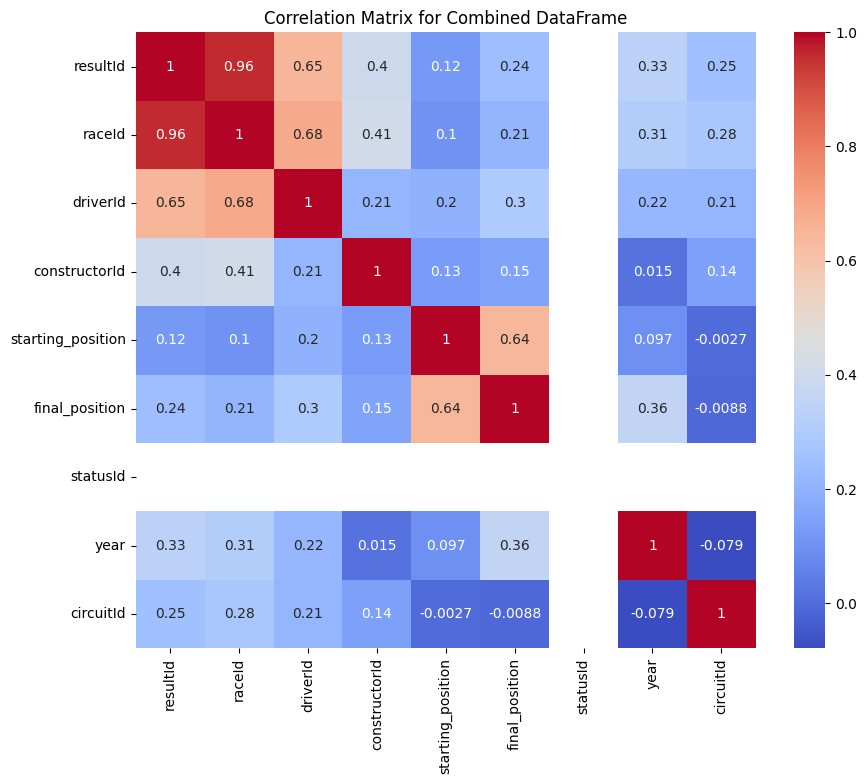

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt

numeric_cols = combined_df.select_dtypes(include=[np.number]).columns
print("Numeric columns:", numeric_cols)

corr_matrix = combined_df[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix for Combined DataFrame")
plt.show()

In [79]:
from sklearn.model_selection import train_test_split

target = 'final_position'
features = ['starting_position', 'year', 'circuitId']
x = combined_df[features]
y = combined_df[target]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

print("X_train shape:", x_train.shape)
print("X_test shape:", x_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (6107, 3)
X_test shape: (1527, 3)
y_train shape: (6107,)
y_test shape: (1527,)


Testing 3 Different Models

In [80]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

model_1 = LinearRegression()
model_1.fit(x_train, y_train)

model_1_predictions = model_1.predict(x_test)

model_1_mae = mean_absolute_error(y_test, model_1_predictions)
model_1_mse = mean_squared_error(y_test, model_1_predictions)
model_1_r2 = r2_score(y_test, model_1_predictions)

print("Linear Regression Metrics:")
print(f"MAE: {model_1_mae:.2f}")
print(f"MSE: {model_1_mse:.2f}")
print(f"R2: {model_1_r2:.2f}\n")

Linear Regression Metrics:
MAE: 1.98
MSE: 6.95
R2: 0.46



In [82]:
from sklearn.ensemble import RandomForestRegressor

model_2 = RandomForestRegressor(n_estimators=100, random_state=0)
model_2.fit(x_train, y_train)

model_2_predictions = model_2.predict(x_test)

model_2_mae = mean_absolute_error(y_test, model_2_predictions)
model_2_mse = mean_squared_error(y_test, model_2_predictions)
model_2_r2 = r2_score(y_test, model_2_predictions)

print("Random Forest Regression Metrics:")
print(f"MAE: {model_2_mae:.2f}")
print(f"MSE: {model_2_mse:.2f}")
print(f"R2: {model_2_r2:.2f}\n")

Random Forest Regression Metrics:
MAE: 1.85
MSE: 6.37
R2: 0.50



In [84]:
from xgboost import XGBRegressor

model_3 = XGBRegressor(n_estimators=100, random_state=0)
model_3.fit(x_train, y_train)

model_3_predictions = model_3.predict(x_test)

model_3_mae = mean_absolute_error(y_test, model_3_predictions)
model_3_mse = mean_squared_error(y_test, model_3_predictions)
modle_3_r2 = r2_score(y_test, model_3_predictions)

print("XGBoost Regression Metrics:")
print(f"MAE: {model_3_mae:.2f}")
print(f"RMSE: {model_3_mse:.2f}")
print(f"R²: {modle_3_r2:.2f}")

XGBoost Regression Metrics:
MAE: 1.79
RMSE: 5.89
R²: 0.54
